# A First Attempt Using Multiple Linear Regression
## Author:                Ian Kinskey
## Created:              April 30, 2017

For Kaggle competition "House Prices: Advanced Regression Techniques":  https://goo.gl/hKF6Iv

[Data Descriptions](data_description.txt)

---
### Log
* Attempt 1:  use stepAIC to find best model.
* Attempt 2:  Use model 1 as jumping off point.  Explore transformations for improved score.

---

## Process

We're going to build a tentative model with little upfront analysis via the following process:
* explore correlations in features
* exploit strongest correlations with SalePrice
* sprinkle in some human intuition
* automate variable selection via stepAIC from MASS package

---

## Housekeeping

Load some libraries

In [1]:
library("MASS")
library("corrplot")
library("mosaic")

Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2
Loading required package: mosaicData
Loading required package: Matrix

The 'mosaic' package masks several functions from core packages in order to add additional features.  
The original behavior of these functions should not be affected by this.

Attaching package: ‘mosaic’

The following object is masked from ‘package:Matrix’:

    mean

The following objects are masked from ‘package:dplyr’:

    count, do, tally

The following objects are masked from ‘package:stats’:

    binom.test, cor, cov, D, fivenum, IQR, median, prop.test, quantile,
    sd, t.test, var

The following objects are masked from ‘package:base’:

    max, mean

Load the data

In [2]:
housing <- read.csv("train.csv")
attach(housing)

The following object is masked from package:mosaicData:

    Utilities



---
## Exploratory Data Analysis

What are dimenions of data?

In [3]:
dim(housing)

[1] 1460   81

There are 80 variables (excluding the Y:  SalePrice), and 1,460 observations.

In [4]:
str(housing)

'data.frame':	1460 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ Alley        : Factor w/ 2 levels "Grvl","Pave": NA NA NA NA NA NA NA NA NA NA ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..:

How many columns contain NAs?

In [5]:
na.cols = which(colSums(is.na(housing)) > 0)
sort(colSums(sapply(housing[na.cols], is.na)), decreasing = TRUE)

PoolQC  MiscFeature        Alley        Fence  FireplaceQu  LotFrontage 
        1453         1406         1369         1179          690          259 
  GarageType  GarageYrBlt GarageFinish   GarageQual   GarageCond BsmtExposure 
          81           81           81           81           81           38 
BsmtFinType2     BsmtQual     BsmtCond BsmtFinType1   MasVnrType   MasVnrArea 
          38           37           37           37            8            8 
  Electrical 
           1

For better or worse, we are going to ignore all of these columns, though some of them may be predictive.

In [6]:
drop <- c('Alley','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','Electrical'
          ,'Fence','FireplaceQu','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt'
          ,'LotFrontage','MasVnrArea','MasVnrType','MiscFeature','PoolQC')

housing2 <- housing[ , !(names(housing) %in% drop)]
dim(housing2)
housing2 <- na.omit(housing2)

[1] 1460   62

Let's log all numeric variables to see if we get better correlations.

In [7]:
numeric_var <- names(housing2)[which(sapply(housing2, is.numeric))]
df.numeric <- housing2[, names(housing2) %in% numeric_var]

In [8]:
str(df.numeric)

'data.frame':	1460 obs. of  35 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ OverallQual  : int  7 6 7 7 8 5 8 7 7 5 ...
 $ OverallCond  : int  5 8 5 5 5 5 5 6 5 6 ...
 $ YearBuilt    : int  2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 ...
 $ YearRemodAdd : int  2003 1976 2002 1970 2000 1995 2005 1973 1950 1950 ...
 $ BsmtFinSF1   : int  706 978 486 216 655 732 1369 859 0 851 ...
 $ BsmtFinSF2   : int  0 0 0 0 0 0 0 32 0 0 ...
 $ BsmtUnfSF    : int  150 284 434 540 490 64 317 216 952 140 ...
 $ TotalBsmtSF  : int  856 1262 920 756 1145 796 1686 1107 952 991 ...
 $ X1stFlrSF    : int  856 1262 920 961 1145 796 1694 1107 1022 1077 ...
 $ X2ndFlrSF    : int  854 0 866 756 1053 566 0 983 752 0 ...
 $ LowQualFinSF : int  0 0 0 0 0 0 0 0 0 0 ...
 $ GrLivArea    : int  1710 1262 1786 1717 2198 1362 1694 2090 1774 1077 ...
 $ BsmtFullB

In [9]:
housing2$log.MSSubClass <- log(MSSubClass)
housing2$log.LotArea <- log(LotArea)
housing2$log.OverallQual <- log(OverallQual)
housing2$log.OverallCond <- log(OverallCond)
housing2$log.YearBuilt <- log(YearBuilt)
housing2$log.YearRemodAdd <- log(YearRemodAdd)
housing2$log.BsmtFinSF1 <- log(BsmtFinSF1)
housing2$log.BsmtFinSF2 <- log(BsmtFinSF2)
housing2$log.BsmtUnfSF <- log(BsmtUnfSF)
housing2$log.TotalBsmtSF <- log(TotalBsmtSF)
housing2$log.X1stFlrSF <- log(X1stFlrSF)
housing2$log.X2ndFlrSF <- log(X2ndFlrSF)
housing2$log.LowQualFinSF <- log(LowQualFinSF)
housing2$log.GrLivArea <- log(GrLivArea)
housing2$log.BsmtFullBath <- log(BsmtFullBath)
housing2$log.BsmtHalfBath <- log(BsmtHalfBath)
housing2$log.FullBath <- log(FullBath)
housing2$log.HalfBath <- log(HalfBath)
housing2$log.BedroomAbvGr <- log(BedroomAbvGr)
housing2$log.KitchenAbvGr <- log(KitchenAbvGr)
housing2$log.TotRmsAbvGrd <- log(TotRmsAbvGrd)
housing2$log.Fireplaces <- log(Fireplaces)
housing2$log.GarageCars <- log(GarageCars)
housing2$log.GarageArea <- log(GarageArea)
housing2$log.WoodDeckSF <- log(WoodDeckSF)
housing2$log.OpenPorchSF <- log(OpenPorchSF)
housing2$log.EnclosedPorch <- log(EnclosedPorch)
housing2$log.X3SsnPorch <- log(X3SsnPorch)
housing2$log.ScreenPorch <- log(ScreenPorch)
housing2$log.PoolArea <- log(PoolArea)
housing2$log.MiscVal <- log(MiscVal)
housing2$log.MoSold <- log(MoSold)
housing2$log.YrSold <- log(YrSold)
housing2$log.SalePrice <- log(SalePrice)
housing2$sqrt.MSSubClass <- sqrt(MSSubClass)
housing2$sqrt.LotArea <- sqrt(LotArea)
housing2$sqrt.OverallQual <- sqrt(OverallQual)
housing2$sqrt.OverallCond <- sqrt(OverallCond)
housing2$sqrt.YearBuilt <- sqrt(YearBuilt)
housing2$sqrt.YearRemodAdd <- sqrt(YearRemodAdd)
housing2$sqrt.BsmtFinSF1 <- sqrt(BsmtFinSF1)
housing2$sqrt.BsmtFinSF2 <- sqrt(BsmtFinSF2)
housing2$sqrt.BsmtUnfSF <- sqrt(BsmtUnfSF)
housing2$sqrt.TotalBsmtSF <- sqrt(TotalBsmtSF)
housing2$sqrt.X1stFlrSF <- sqrt(X1stFlrSF)
housing2$sqrt.X2ndFlrSF <- sqrt(X2ndFlrSF)
housing2$sqrt.LowQualFinSF <- sqrt(LowQualFinSF)
housing2$sqrt.GrLivArea <- sqrt(GrLivArea)
housing2$sqrt.BsmtFullBath <- sqrt(BsmtFullBath)
housing2$sqrt.BsmtHalfBath <- sqrt(BsmtHalfBath)
housing2$sqrt.FullBath <- sqrt(FullBath)
housing2$sqrt.HalfBath <- sqrt(HalfBath)
housing2$sqrt.BedroomAbvGr <- sqrt(BedroomAbvGr)
housing2$sqrt.KitchenAbvGr <- sqrt(KitchenAbvGr)
housing2$sqrt.TotRmsAbvGrd <- sqrt(TotRmsAbvGrd)
housing2$sqrt.Fireplaces <- sqrt(Fireplaces)
housing2$sqrt.GarageCars <- sqrt(GarageCars)
housing2$sqrt.GarageArea <- sqrt(GarageArea)
housing2$sqrt.WoodDeckSF <- sqrt(WoodDeckSF)
housing2$sqrt.OpenPorchSF <- sqrt(OpenPorchSF)
housing2$sqrt.EnclosedPorch <- sqrt(EnclosedPorch)
housing2$sqrt.X3SsnPorch <- sqrt(X3SsnPorch)
housing2$sqrt.ScreenPorch <- sqrt(ScreenPorch)
housing2$sqrt.PoolArea <- sqrt(PoolArea)
housing2$sqrt.MiscVal <- sqrt(MiscVal)
housing2$sqrt.MoSold <- sqrt(MoSold)
housing2$sqrt.YrSold <- sqrt(YrSold)
housing2$sqrt.SalePrice <- sqrt(SalePrice)

In [10]:
numeric_var <- names(housing2)[which(sapply(housing2, is.numeric))]
df.numeric <- housing2[, names(housing2) %in% numeric_var]
str(df.numeric)

'data.frame':	1460 obs. of  103 variables:
 $ Id                : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass        : int  60 20 60 70 60 50 20 60 50 190 ...
 $ LotArea           : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ OverallQual       : int  7 6 7 7 8 5 8 7 7 5 ...
 $ OverallCond       : int  5 8 5 5 5 5 5 6 5 6 ...
 $ YearBuilt         : int  2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 ...
 $ YearRemodAdd      : int  2003 1976 2002 1970 2000 1995 2005 1973 1950 1950 ...
 $ BsmtFinSF1        : int  706 978 486 216 655 732 1369 859 0 851 ...
 $ BsmtFinSF2        : int  0 0 0 0 0 0 0 32 0 0 ...
 $ BsmtUnfSF         : int  150 284 434 540 490 64 317 216 952 140 ...
 $ TotalBsmtSF       : int  856 1262 920 756 1145 796 1686 1107 952 991 ...
 $ X1stFlrSF         : int  856 1262 920 961 1145 796 1694 1107 1022 1077 ...
 $ X2ndFlrSF         : int  854 0 866 756 1053 566 0 983 752 0 ...
 $ LowQualFinSF      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ GrLivArea      

In [11]:
# need the SalePrice column
correlations = cor(df.numeric)

In [12]:
corr.SalePrice = as.matrix(sort(correlations[,'log.SalePrice'], decreasing = TRUE))

In [13]:
corr.idx = names(which(apply(corr.SalePrice, 1, function(x) (x > 0.5 | x < -0.5))))

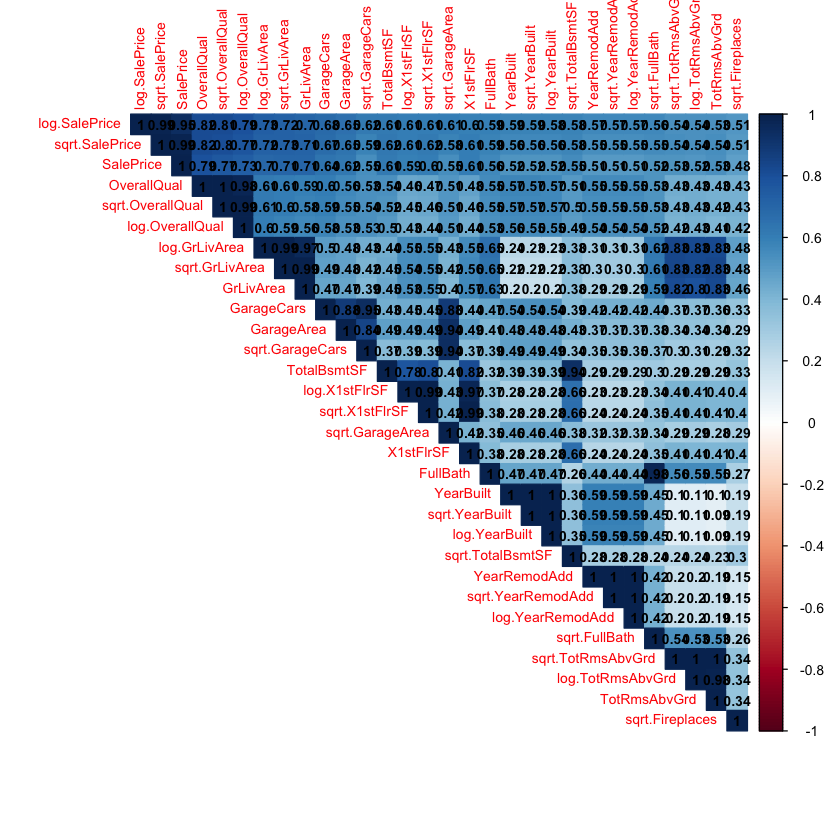

In [14]:
corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'black', tl.cex = .7,cl.cex = .7, number.cex=.7)

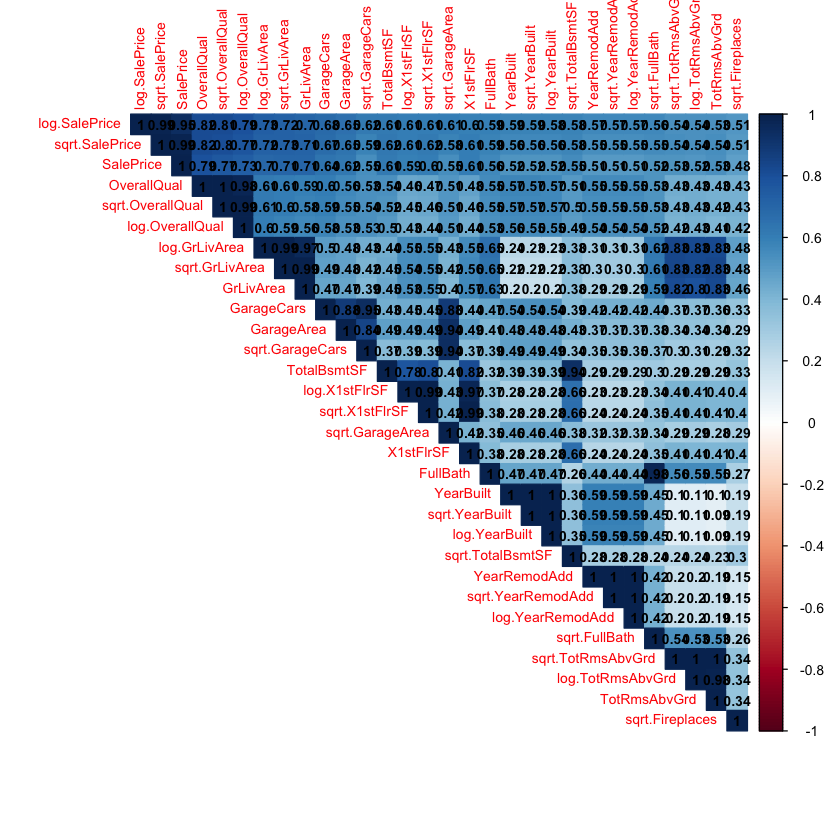

In [15]:
corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'black', tl.cex = .7,cl.cex = .7, number.cex=.7)

In [16]:
lm2 <- lm(formula = log(SalePrice) ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + log.GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + log.OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    log.TotRmsAbvGrd + YearBuilt + YearRemodAdd + log.X1stFlrSF + sqrt.Fireplaces , data = housing2)

In [25]:
lm3 <- lm(formula = log(SalePrice) ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + log.GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + log.OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    log.TotRmsAbvGrd + YearBuilt + YearRemodAdd + log.X1stFlrSF , data = housing2)

In [17]:
summary(lm2)


Call:
lm(formula = log(SalePrice) ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + log.GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + log.OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    log.TotRmsAbvGrd + YearBuilt + YearRemodAdd + log.X1stFlrSF + 
    sqrt.Fireplaces, data = housing2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70901 -0.06089  0.00093  0.06511  0.49603 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -8.756e-01  7.484e-01  -1.170 0.242240    
BldgType2fmCon        4.134e-03  2.518e-02   0.164 0.869627    
BldgTypeDuplex       -1.057e-01  2.202e-02  -4.800 1.76e-06 ***
BldgTypeTwnhs        -1.063e-01  2.658e-02  -4.000 6.67e-05 ***
BldgTypeTwnhsE       -6.131e-02  1.794e-02  -3.417 0.000653 ***
CentralAirY           9.702e-02  1.7

In [26]:
summary(lm3)


Call:
lm(formula = log(SalePrice) ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + log.GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + log.OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    log.TotRmsAbvGrd + YearBuilt + YearRemodAdd + log.X1stFlrSF, 
    data = housing2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70304 -0.06385  0.00229  0.06754  0.50186 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -8.053e-01  7.548e-01  -1.067 0.286203    
BldgType2fmCon        2.467e-03  2.540e-02   0.097 0.922622    
BldgTypeDuplex       -1.228e-01  2.193e-02  -5.598 2.63e-08 ***
BldgTypeTwnhs        -1.119e-01  2.679e-02  -4.176 3.16e-05 ***
BldgTypeTwnhsE       -6.125e-02  1.810e-02  -3.384 0.000735 ***
CentralAirY           1.049e-01  1.794e-02   5.846 6.3

In [27]:
test <- read.csv("test.csv")

In [29]:
test$log.TotRmsAbvGrd <- log(test$TotRmsAbvGrd)
test$log.GrLivArea <- log(test$GrLivArea)
test$log.OverallQual <- log(test$OverallQual)
test$log.X1stFlrSF <- log(test$X1stFlrSF)
test$sqrt.Fireplaces <- sqrt(test$Fireplaces)

In [31]:
test[1,c('BldgType','CentralAir','Condition1','Condition2','ExterQual','Functional','GarageArea','log.GrLivArea','Heating','HouseStyle','KitchenQual','LandContour','LandSlope','LotConfig','LotShape','MSZoning','Neighborhood','log.OverallQual','RoofMatl','RoofStyle','SaleCondition','SaleType','TotalBsmtSF','log.TotRmsAbvGrd','YearBuilt','YearRemodAdd','log.X1stFlrSF')]

BldgType,CentralAir,Condition1,Condition2,ExterQual,Functional,GarageArea,log.GrLivArea,Heating,HouseStyle,⋯,log.OverallQual,RoofMatl,RoofStyle,SaleCondition,SaleType,TotalBsmtSF,log.TotRmsAbvGrd,YearBuilt,YearRemodAdd,log.X1stFlrSF
1Fam,Y,Feedr,Norm,TA,Typ,730,6.79794,GasA,1Story,⋯,1.609438,CompShg,Gable,Normal,WD,882,1.609438,1961,1961,6.79794


In [32]:
z <- data.frame(predict(lm2, test[,c('BldgType','CentralAir','Condition1','Condition2','ExterQual','Functional','GarageArea','log.GrLivArea','Heating','HouseStyle','KitchenQual','LandContour','LandSlope','LotConfig','LotShape','MSZoning','Neighborhood','log.OverallQual','RoofMatl','RoofStyle','SaleCondition','SaleType','TotalBsmtSF','log.TotRmsAbvGrd','YearBuilt','YearRemodAdd','log.X1stFlrSF','sqrt.Fireplaces')]))

In [33]:
colnames(z) <- "log.SalePrice"

In [35]:
write.table(z, file = "ik_predict5.csv", sep=",")

### To Do:

* Comment and clean up existing code!  Jeez man, itsa messy!  Itsa such a mess!
* Regression diagnostics
* Why are nulls appearing in prediction?
* Encoding of categorical vars
* Can null numerics be filled via modeling?